In [28]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2

import platform

In [29]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz


In [32]:
# setting seed for PRNGs
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
tf.test.gpu_device_name()
tf.__version__

'2.8.2'

In [34]:
from tools.misc_tools import create_Lorenz_data, create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data, plot_latent_states, readAndReturnLossHistories
from tools.ae_v3 import Autoencoder
from tools.LSTM_AR_v2 import AR_RNN_LSTM
from tools.Combined_AE_RNN_v1 import Combined_AE_RNN


In [35]:
behaviour = 'loadFromIndivduallyTrained'
# behaviour = 'loadFromCombineTrained'

In [36]:
# setting up params

from numpy import *

### Simutlation paramaters
if behaviour == 'loadFromIndivduallyTrained':
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_011'
    dir_sim_data = dir_name_rnn
    dir_rnn_data = dir_name_rnn
else:
    dir_name_ae_rnn = os.getcwd()+'/saved_ae_rnn/ae_rnn_005'
    # dir_name_rnn = dir_name_ae_rnn + '{ds}initial_net{ds}RNN'.format(ds=dir_sep)
    # dir_name_ae = dir_name_ae_rnn + '{ds}initial_net{ds}AE'.format(ds=dir_sep)
    dir_sim_data = dir_name_ae_rnn
    dir_rnn_data = dir_name_ae_rnn

with open(dir_sim_data + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))


dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]

rho_arr = params_dict['rho_arr']
sigma_arr = params_dict['sigma_arr']
beta_arr = params_dict['beta_arr']

x0 = params_dict['x0']
y0 = params_dict['y0']
z0 = params_dict['z0']

t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']

normalize_flag = params_dict['normalize_flag']


### RNN paramaters
with open(dir_rnn_data + '/RNN_specific_data.txt') as f:
    lines = f.readlines()

params_rnn_dict = eval(''.join(lines))

dt_rnn = params_rnn_dict['dt_rnn']
T_sample_input = params_rnn_dict['T_sample_input']
T_sample_output = params_rnn_dict['T_sample_output']
T_offset = params_rnn_dict['T_offset']
return_params_arr = params_rnn_dict['return_params_arr']

In [37]:
res_dict = create_Lorenz_data(
    T, t0, delta_t,
    rho_arr, sigma_arr, beta_arr,
    x0, y0, z0, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']

if return_params_arr == True:
    params_arr = res_dict['params_arr']

if normalize_flag == True:
    normalization_constant_arr = res_dict['normalization_constant_arr']

In [38]:
n = len(boundary_idx_arr)

# Autoencoder

In [39]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

if behaviour == 'loadFromIndivduallyTrained':
    load_file = dir_name_ae + '{ds}final_net{ds}'.format(ds=dir_sep)
elif behaviour == 'loadFromCombineTrained':
    load_file = dir_name_ae_rnn + '{ds}final_net{ds}AE{ds}'.format(ds=dir_sep)

wt_file = load_file + 'final_net_ae_weights.h5'
load_file += 'final_net_class_dict.txt'

In [40]:
ae_net = Autoencoder(6, load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [41]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


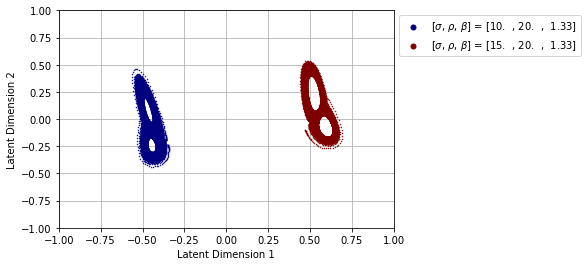

In [42]:
fig, ax = plot_latent_states(
    boundary_idx_arr=boundary_idx_arr,
    latent_states_all=latent_states_all,
    all_data=all_data,
    xlim=[-1,1],
    ylim=[-1,1],
    cmap_name='jet')

# LSTM

In [43]:
if behaviour == 'loadFromIndivduallyTrained':
    rnn_load_file_path = dir_name_rnn+'{ds}final_net{ds}'.format(ds=dir_sep)
elif behaviour == 'loadFromCombineTrained':
    rnn_load_file_path = dir_name_ae_rnn + '{ds}final_net{ds}RNN{ds}'.format(ds=dir_sep)

rnn_weights_path = rnn_load_file_path + 'final_net_lstm_weights.h5'
rnn_load_file_path += 'final_net_class_dict.txt'

In [44]:
rnn_net = AR_RNN_LSTM(
    load_file=rnn_load_file_path,
    T_input=T_sample_input,
    T_output=T_sample_output)
temp = rnn_net.predict(tf.ones(shape=[1, 1, rnn_net.data_dim]))
rnn_net.load_weights_from_file(file_name=rnn_weights_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [45]:
# rnn_net = RNN_LSTM(load_file=rnn_load_file_path)
# temp = rnn_net.predict(tf.ones(shape=[1, 1, rnn_net.data_dim]))
# rnn_net.load_weights_from_file(file_name=rnn_weights_path[0:-3])

In [46]:
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=losses.MeanSquaredError(),
    run_eagerly=True
)

# AE-RNN

In [47]:
from tools.misc_tools import create_data_for_RNN
from tools.AE_RNN_v3 import AE_RNN

In [48]:
tf.config.run_functions_eagerly(True)

ae_rnn = AE_RNN(
    encoder_net=ae_net.encoder_net,
    decoder_net=ae_net.decoder_net,
    rnn_net=rnn_net
)

In [53]:
dt_rnn = rnn_net.dt_rnn
# dt_rnn = 0.1
T_input = dt_rnn + 0.25*dt_rnn
T_output = 30 + 0.25*dt_rnn
# T_output = 50*dt_rnn + 0.25*dt_rnn
T_offset = dt_rnn
params = None

print('  dt_rnn : {}'.format(dt_rnn))
print(' T_input : {}'.format(T_input))
print('T_output : {}\n'.format(T_output))

# data_rnn_input, data_rnn_output, org_data_idx_arr_input, org_data_idx_arr_output = create_data_for_RNN(
#     latent_states_all,
#     dt_rnn,
#     T_sample_input,
#     T_sample_output,
#     T_offset,
#     N,
#     boundary_idx_arr,
#     delta_t,
#     params=params)

  dt_rnn : 0.01
 T_input : 0.0125
T_output : 30.0025



  num_input : 1
 num_output : 3000
idx_to_skip : 1



/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


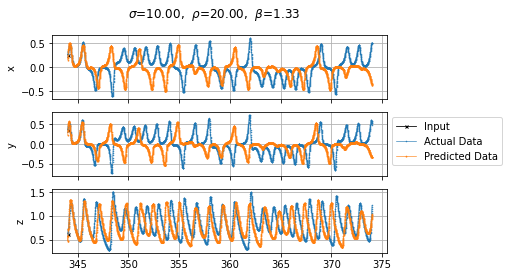

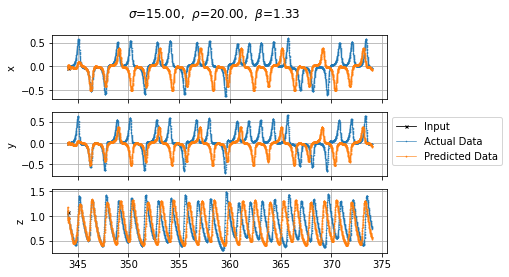

In [54]:
n = len(boundary_idx_arr)

# T_input = dt_rnn
# T_output = 25
num_input = int(T_input // dt_rnn)
num_output = int(T_output // dt_rnn)
idx_to_skip = int(dt_rnn // delta_t)

print('  num_input : {}'.format(num_input))
print(' num_output : {}'.format(num_output))
print('idx_to_skip : {}\n'.format(idx_to_skip))

save_dir = dir_rnn_data+dir_sep+'plots'+dir_sep+'AE_RNN'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

num_digits_n = int(np.log10(n)+1)
# starting_idx = int(70/delta_t)
starting_idx = int(np.random.uniform()*(N-idx_to_skip*(num_input+num_output)))

for i in range(len(boundary_idx_arr)):
    u_input = all_data[i*(N+1)+starting_idx:i*(N+1)+starting_idx + idx_to_skip*num_input:idx_to_skip, :].reshape(1, num_input, 6)
    output_exact = all_data[(N+1)*i+starting_idx+idx_to_skip*num_input:i*(N+1)+starting_idx + idx_to_skip*(num_input+num_output):idx_to_skip]
    if return_params_arr is not True:
        params = None
    else:
        params = params_arr[i, :]
        
    output_predicted = ae_rnn.predict(inputs=u_input, out_time=T_output)#, training=False, params=params)


    fig, ax = plt.subplots(3, 1, sharex=True)
    ax_ylabels = ['x', 'y', 'z']
    ax_plots = [None]*3
    for j in range(3):
        input_time = delta_t*np.arange(starting_idx, num_input*idx_to_skip+starting_idx, idx_to_skip)
        output_time = input_time[-1] + dt_rnn*np.arange(1, 1 + num_output, 1)
        
        ax_plots[0] = ax[j].plot(input_time, u_input[0, :, j], marker='x', color='k', markersize=3, linewidth=0.8)#, label='_nolegend_')
        ax_plots[1] = ax[j].plot(output_time, output_exact[:, j], marker='.', linewidth=0.6, markersize=1)#, label='Actual Data')
        ax_plots[2] = ax[j].plot(output_time, output_predicted[0, :, j], marker='^', linewidth=0.6, markersize=1)#, label='Predicted Data')
        
#         ax[j].legend()
        if j == 1:
            ax[j].legend(labels=['Input', 'Actual Data', 'Predicted Data'], bbox_to_anchor=(1,1))
        ax[j].grid()
        ax[j].set_ylabel(ax_ylabels[j])
        
    fig.suptitle(r'$\sigma$={:.2f},  $\rho$={:.2f},  $\beta$={:.2f}'.format(all_data[i*(N+1), 3], all_data[i*(N+1), 4], all_data[i*(N+1), 5]))
#     fig.legend(labels=['Input', 'Actual Data', 'Predicted Data'], bbox_to_anchor=(1.2,0.5))
    # plt.savefig(save_dir+dir_sep+'AE_RNN-prediction-{}.png'.format(str(i+1).zfill(num_digits_n)), dpi=300, bbox_inches='tight')

In [51]:
rnn_net.out_steps

3000

In [52]:
n = len(boundary_idx_arr)

T_input = 10 + 0.5*dt_rnn
T_output = 10 + 0.5*dt_rnn
T_offset = dt_rnn + 0.5*dt_rnn

num_input = int(T_input // dt_rnn)
num_output = int(T_output // dt_rnn)
num_offset = int(T_offset // dt_rnn)
idx_to_skip = int(dt_rnn // delta_t)

# save_dir = dir_rnn_data+dir_sep+'plots'+dir_sep+'AE_RNN'
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)

num_digits_n = int(np.log10(n)+1)
starting_idx = int(np.random.uniform()*(N-num_output))
print('starting_idx : {}'.format(starting_idx))
for i in range(len(boundary_idx_arr)):
    u_input = all_data[i*(N+1)+starting_idx:i*(N+1)+starting_idx + idx_to_skip*num_input:idx_to_skip, :].reshape(1, num_input, 6)
    output_exact = all_data[(N+1)*i+starting_idx+idx_to_skip*num_offset:i*(N+1)+starting_idx+ idx_to_skip*(num_offset+num_output):idx_to_skip]
    if return_params_arr is not True:
        params = None
    else:
        params = params_arr[i, :]
        
    output_predicted = ae_rnn.predict(inputs=u_input, out_time=T_output, training=False, params=params)


    fig = plot_reconstructed_data(
        boundary_idx_arr=[num_input],
        dir_name_ae=dir_name_rnn,
        all_data=u_input[0],
        reconstructed_data=output_exact,
        save_figs=False)

starting_idx : 46585


TypeError: ignored

In [ ]:
boundary_idx_arr